In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from utils.input_pipeline import load_data

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
with open("data/preprocessed_features.csv", "r") as input_file:
    feature_list = []
    for line in input_file:
        line = line.strip('\n')
        feature_list.append(line)
        
print(len(feature_list))

890


In [3]:
X_input,y_input = load_data("data/full_26_kinase_data.h5",features_list = feature_list)


  0%|          | 0/26 [00:00<?, ?it/s]

loading 26 proteins.


100%|██████████| 26/26 [06:13<00:00, 15.84s/it]


In [4]:
from sklearn.preprocessing import Imputer, Normalizer
imputer = Imputer()
normalizer = Normalizer()
X_input = normalizer.fit_transform(imputer.fit_transform(X_input))

In [5]:
x_train,x_test,y_train,y_test = train_test_split(X_input,y_input,stratify=y_input,test_size=0.2)


In [6]:
print(X_input.shape[1])

890


In [7]:
from keras.callbacks import TensorBoard
from keras import regularizers
batch_size = 100
original_dim = X_input.shape[1]
latent_dim = 1
intermediate_dim = 500
epochs = 10
epsilon_std = 1.0

x = Input(shape=(int(original_dim),))
h = Dense(intermediate_dim, activation='relu', bias_regularizer=regularizers.l2(l=0))(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)



def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim,), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu', bias_regularizer=regularizers.l2(l=0))
decoder_mean = Dense(original_dim, activation='sigmoid',bias_regularizer=regularizers.l2(l=0))
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)

print(vae.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 890)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 500)           445500      input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             501         dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1)             501         dense_1[0][0]                    
___________________________________________________________________________________________

In [8]:
vae.compile(optimizer='rmsprop', loss='mse')


# train the VAE on MNIST digits

vae.fit(x_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,validation_split=0.2, verbose=0, callbacks=
        [TensorBoard(log_dir='logs/vae/'+str(time.time()), batch_size=batch_size, write_graph=True, write_grads=True)])





In [9]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [10]:
# display a 2D plot of the classes in the latent space
#plt.clf()
#plt.style.use('ggplot')

x_test_encoded = encoder.predict(x_test)
#plt.figure(figsize=(15, 10))
#plt.scatter(x_test_encoded[y_test.flatten()==0][:, 0], x_test_encoded[y_test.flatten()==0][:, 1], c=y_test.flatten()[y_test.flatten()==0], s=0.1)
#plt.scatter(x_test_encoded[y_test.flatten()==1][:, 0], x_test_encoded[y_test.flatten()==1][:, 1], c=y_test.flatten()[y_test.flatten()==1], s=10)

#plt.colorbar()
#plt.show()

In [11]:
#from mpl_toolkits.mplot3d import Axes3D
#import random


#plt.clf()

#fig = plt.figure(figsize=(5,5))
#ax = Axes3D(fig)
#ax.scatter3D(x_test_encoded[y_test.flatten()==0][:, 0], 
#            x_test_encoded[y_test.flatten()==0][:, 1], x_test_encoded[y_test.flatten()==0][:, 2], c='b', s=0.1)
#ax.scatter3D(x_test_encoded[y_test.flatten()==1][:, 0], 
#            x_test_encoded[y_test.flatten()==1][:, 1], x_test_encoded[y_test.flatten()==1][:, 2], c='r', s=2)
#plt.show()


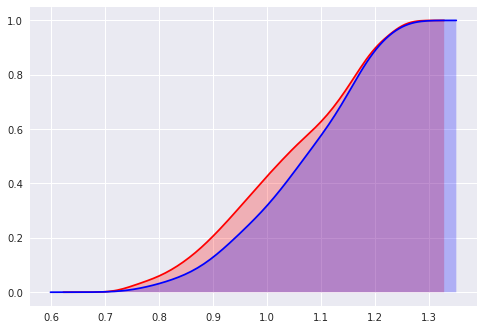

In [16]:
import matplotlib.pyplot as plt
import statsmodels
#from scipy.stats import gaussian_kde
import seaborn as sns

#measure overlap

sns.kdeplot(x_test_encoded[:,0][y_test.flatten()==0],shade=True, color="r", cumulative=True)
sns.kdeplot(x_test_encoded[:,0][y_test.flatten()==1],shade=True, color="b", cumulative=True)
#sns.kdeplot(x_test_encoded[:,0],shade=True, color="g", cumulative=True)
plt.show()

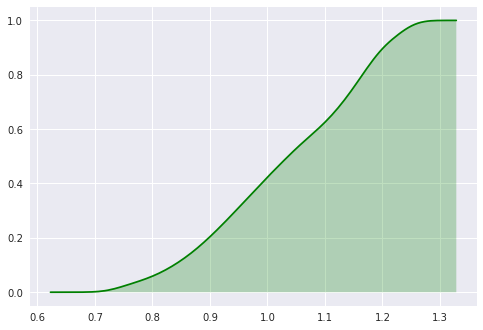

In [15]:
sns.kdeplot(x_test_encoded[:,0],shade=True, color="g", cumulative=True)
plt.show()

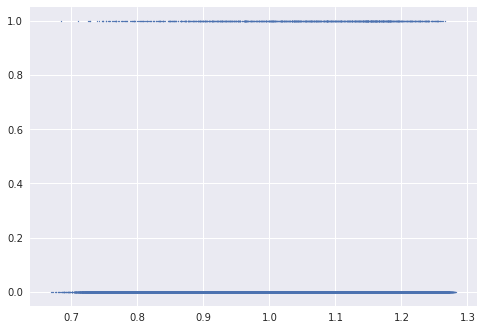

In [14]:
plt.scatter(x_test_encoded,y_test,s=1)
plt.show()